In [4]:
from pathlib import Path
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
import random 
from PIL import Image

In [5]:
stencils = []

for file in Path("pochoirs_patchwork").iterdir() :
    if file.suffix.lower() == ".png" :
        stencils.append(imread(file))

In [6]:
textures = []

for file in Path("textures_uniques").iterdir() :
    if file.suffix.lower() == ".tiff" :
        textures.append(imread(file))

In [7]:
def generate_patchwork(stencils, textures, stencil_idx=None) :
    if stencil_idx is None:
        stencil = random.choice(stencils)
    else:
        stencil = stencils[stencil_idx]
    labels = np.unique(stencil)
    nb_labels = len(labels)
    texture_indices = random.sample(range(len(textures)), nb_labels)
    label_to_tex_idx = dict(zip(labels, texture_indices))
    H, W = stencil.shape
    patchwork = np.zeros((H, W), dtype=textures[0].dtype)
    labels_bottom = np.unique(stencil[-2:, :]) 
    for l in labels:
        tex = textures[label_to_tex_idx[l]]
        if l in labels_bottom:
            tex = tex[::-1, ...]
        mask = (stencil == l)
        patchwork[mask] = tex[mask]

    plt.figure(figsize=(5,5))
    plt.imshow(patchwork, cmap="gray")
    plt.axis("off")
    plt.show()

    return patchwork

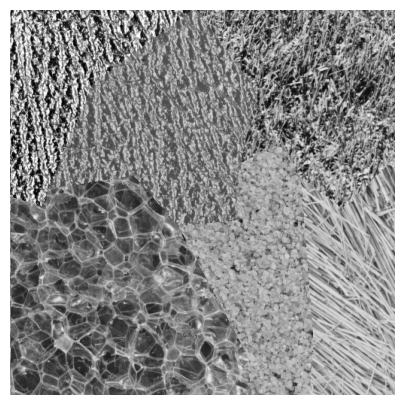

In [36]:
patchwork = generate_patchwork(stencils=stencils, textures=textures, stencil_idx=3)

In [42]:
#attention, il faut indiquer un nouveau nom à chaque fois pour l'image sinon elles s'écrasent 
Image.fromarray(patchwork).save("patchworks/patchwork10.png")